#사용법

1. 우측 상단 '로그인'

2. 좌측 상단 '실습 모드에서 열기' 또는 'Drive에 사본 저장'

※ 각각의 셀은 셀 좌측 상단 실행 버튼을 통해 실행할 수 있습니다.

※ 혹은 CTRL + ENTER로 실행 가능합니다.

※ 실행 중 '경고: 이 노트는 Google에서 작성하지 않았습니다.'라는 창이 뜰 경우, '실행 전에 모든 런타임 재설정'란에 체크 후 '무시하고 계속하기'를 하시면 됩니다.

본 실습 참고 자료: 밑바닥부터 시작하는 딥러닝2

링크: https://github.com/ExcelsiorCJH/DLFromScratch2

In [1]:
# google drive 연동
# 모두 '예' 선택
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/nlp_basic/

/content/drive/MyDrive/nlp_basic


# Seq2Seq 구조

seq2seq는 Encoder와 Decoder로 나누어져 있습니다.

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/seq2seq.png?raw=true" width=800>

위 그림에서는 디코더에 입력이 \<start\>를 제외하고 나머지 토큰은 모두 디코더가 스스로 생성하는 것처럼 보입니다.

하지만 처음 학습시에는 매우 예측력이 떨어지기 때문에 매우 이상한 토큰을 생성합니다.

그런데 디코더가 생성한 이상한 토큰으로 계속 진행되게 되면, 그 다음 시점은 전부 학습이 어려워지게 됩니다.

따라서 학습 시에는 디코더에도 정답을 넣어주고, 정답을 기반으로 다음 토큰을 예측하도록 합니다.

이를 Teacher Forcing 이라고 합니다.

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/teacher.png?raw=true" width=500>


In [17]:
# coding: utf-8
from common.time_layers import *
from common.base_model import BaseModel

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')

        # Encoder의 출력은 Affine 변환으로 하는 작업이 없기 때문에 쓰지 않는다.
        #affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        #affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.rnn = TimeRNN(rnn_Wx, rnn_Wh, rnn_b)

        self.params = self.embed.params + self.rnn.params
        self.grads = self.embed.grads + self.rnn.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.rnn.forward(xs)
        self.hs = hs
        return hs[:, -1, :] # 마지막 상태만 Decoder로 넘어갑니다.

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        dout = self.rnn.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')

        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.rnn = TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.rnn, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.rnn.set_state(h)

        out = self.embed.forward(xs)
        out = self.rnn.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.rnn.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.rnn.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.rnn.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.rnn.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        h = self.encoder.forward(xs)

        # 디코더의 입력은 정답의 마지막 요소를 제외하고 넣어줌
        # 디코더의 레이블은 처음 요소를 제외시킴
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        # 만약 정답(ts)가 [<start>, 1, 2, 3, <end>] 라는 시퀀스라면,
        # Deocder의 입력 decoder_xs는 [<start>, 1, 2, 3] 가 됩니다.
        # <end> 는 마지막 시퀀스이고, 다음에 예측할 단어가 없기 때문에 넣을 필요 없습니다.
        # Deocder의 출력 레이블인 decoder_ts는 [1, 2, 3, <end>] 가 됩니다.
        # <start>는 예측할 필요가 없기 때문에 넣지 않습니다.

        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled


# 학습 데이터

본 실습에서 사용할 데이터는 덧셈 데이터입니다.

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/addition.png?raw=true" width=500>

모든 입력 데이터는 공백 포함 7자이며,

모든 출력 데이터 또한 공백 포함 5자로 고정합니다.


샘플 별로 길이가 다르기 때문에, 이를 맞춰주기 위해 적절히 공백을 추가합니다
이러한 작업을 Padding이라고 합니다.

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/addition2.png?raw=true" width=500>


In [18]:
# 데이터 예시
from dataset import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()
print(char_to_id) # Vocabulary
print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
print(x_train[0])
print(t_train[0])
print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

{'1': 0, '6': 1, '+': 2, '7': 3, '5': 4, ' ': 5, '_': 6, '9': 7, '2': 8, '0': 9, '3': 10, '8': 11, '4': 12}
(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


# Seq2seq 학습 시작

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.14
| 에폭 1 |  반복 41 / 351 | 시간 0[s] | 손실 1.93
| 에폭 1 |  반복 61 / 351 | 시간 0[s] | 손실 1.91
| 에폭 1 |  반복 81 / 351 | 시간 1[s] | 손실 1.85
| 에폭 1 |  반복 101 / 351 | 시간 1[s] | 손실 1.78
| 에폭 1 |  반복 121 / 351 | 시간 1[s] | 손실 1.75
| 에폭 1 |  반복 141 / 351 | 시간 1[s] | 손실 1.72
| 에폭 1 |  반복 161 / 351 | 시간 1[s] | 손실 1.70
| 에폭 1 |  반복 181 / 351 | 시간 2[s] | 손실 1.68
| 에폭 1 |  반복 201 / 351 | 시간 2[s] | 손실 1.66
| 에폭 1 |  반복 221 / 351 | 시간 2[s] | 손실 1.64
| 에폭 1 |  반복 241 / 351 | 시간 2[s] | 손실 1.64
| 에폭 1 |  반복 261 / 351 | 시간 3[s] | 손실 1.62
| 에폭 1 |  반복 281 / 351 | 시간 3[s] | 손실 1.59
| 에폭 1 |  반복 301 / 351 | 시간 3[s] | 손실 1.59
| 에폭 1 |  반복 321 / 351 | 시간 3[s] | 손실 1.58
| 에폭 1 |  반복 341 / 351 | 시간 4[s] | 손실 1.56
Q 77+85  
T 162 
☒ 106 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 598 
---
Q 8+155  
T 163 
☒ 996 
---
Q 367+55 
T 422 
☒ 695 
---
Q 600+257
T 857 
☒ 1023
---
Q 761+292
T 1053
☒ 1002
---
Q 830+597
T 1427
☒ 1264
---
Q 26+838

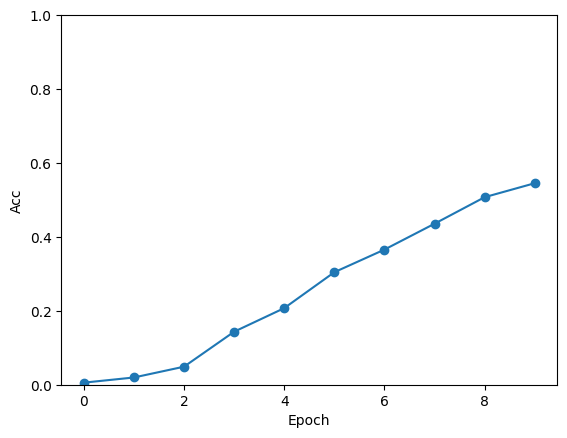

In [30]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=False)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.ylim(0, 1.0)
plt.show()

# Seq2Seq with Attention 구조

이제 seq2seq의 문제점을 해결하기 위한 Attention 레이어를 추가할 차례입니다.

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/seq2seq_attention.png?raw=true" width=800>


Attention 계층에서는 Encoder의 Context Vector(hiddens states)와 Decoder의 hidden states간 내적을 통해서 Attention Score를 구하고 이를 기반으로 Weighted Sum Vector를 구하는 것이 전부입니다.

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/seq2seq_attention2.png?raw=true" width=800>



In [22]:
from common.np import *  # NumPy 관련 함수들을 가져옵니다.
from common.layers import Softmax  # Softmax 계층을 가져옵니다.


class WeightSum:
    """
    가중치 합 계층입니다.
    어텐션 가중치를 사용하여 입력 hidden state들을 가중 평균하여 context vector를 계산합니다.
    """
    def __init__(self):
        self.params, self.grads = [], []  # 파라미터와 기울기를 저장할 리스트를 초기화합니다.
        self.cache = None  # forward 계산 결과를 저장할 캐시를 초기화합니다.

    def forward(self, hs, a):
        """
        순전파 계산을 수행합니다.

        Args:
            hs: 입력 hidden state들. (N, T, H) shape.
            a: 어텐션 가중치. (N, T) shape.

        Returns:
            c: context vector. (N, H) shape.
        """
        N, T, H = hs.shape  # 배치 크기, 시퀀스 길이, hidden state 크기를 가져옵니다.

        ar = a.reshape(N, T, 1)  # 어텐션 가중치를 (N, T, 1) shape으로 변형합니다.
        t = hs * ar  # hidden state들에 어텐션 가중치를 곱합니다.
        c = np.sum(t, axis=1)  # 가중치가 적용된 hidden state들을 합하여 context vector를 계산합니다.

        self.cache = (hs, ar)  # 역전파 계산을 위해 hidden state들과 어텐션 가중치를 캐시에 저장합니다.
        return c  # context vector를 반환합니다.

    def backward(self, dc):
        """
        역전파 계산을 수행합니다.

        Args:
            dc: context vector의 기울기. (N, H) shape.

        Returns:
            dhs: 입력 hidden state들의 기울기. (N, T, H) shape.
            da: 어텐션 가중치의 기울기. (N, T) shape.
        """
        hs, ar = self.cache  # 캐시에서 hidden state들과 어텐션 가중치를 가져옵니다.
        N, T, H = hs.shape  # 배치 크기, 시퀀스 길이, hidden state 크기를 가져옵니다.
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)  # context vector의 기울기를 (N, T, H) shape으로 변형합니다.
        dar = dt * hs  # 어텐션 가중치의 기울기를 계산합니다.
        dhs = dt * ar  # hidden state들의 기울기를 계산합니다.
        da = np.sum(dar, axis=2)  # 어텐션 가중치의 기울기를 합하여 (N, T) shape으로 만듭니다.

        return dhs, da  # hidden state들의 기울기와 어텐션 가중치의 기울기를 반환합니다.


class AttentionWeight:
    """
    어텐션 가중치 계층입니다.
    입력 hidden state들과 현재 hidden state를 사용하여 어텐션 가중치를 계산합니다.
    """
    def __init__(self):
        self.params, self.grads = [], []  # 파라미터와 기울기를 저장할 리스트를 초기화합니다.
        self.softmax = Softmax()  # Softmax 계층을 초기화합니다.
        self.cache = None  # forward 계산 결과를 저장할 캐시를 초기화합니다.

    def forward(self, hs, h):
        """
        순전파 계산을 수행합니다.

        Args:
            hs: 입력 hidden state들. (N, T, H) shape.
            h: 현재 hidden state. (N, H) shape.

        Returns:
            a: 어텐션 가중치. (N, T) shape.
        """
        N, T, H = hs.shape  # 배치 크기, 시퀀스 길이, hidden state 크기를 가져옵니다.

        hr = h.reshape(N, 1, H)  # 현재 hidden state를 (N, 1, H) shape으로 변형합니다.
        t = hs * hr  # 입력 hidden state들과 현재 hidden state를 곱합니다.
        s = np.sum(t, axis=2)  # 곱셈 결과를 합하여 (N, T) shape으로 만듭니다.
        a = self.softmax.forward(s)  # Softmax 함수를 적용하여 어텐션 가중치를 계산합니다.

        self.cache = (hs, hr)  # 역전파 계산을 위해 입력 hidden state들과 현재 hidden state를 캐시에 저장합니다.
        return a  # 어텐션 가중치를 반환합니다.

    def backward(self, da):
        """
        역전파 계산을 수행합니다.

        Args:
            da: 어텐션 가중치의 기울기. (N, T) shape.

        Returns:
            dhs: 입력 hidden state들의 기울기. (N, T, H) shape.
            dh: 현재 hidden state의 기울기. (N, H) shape.
        """
        hs, hr = self.cache  # 캐시에서 입력 hidden state들과 현재 hidden state를 가져옵니다.
        N, T, H = hs.shape  # 배치 크기, 시퀀스 길이, hidden state 크기를 가져옵니다.

        ds = self.softmax.backward(da)  # Softmax 함수의 역전파를 계산합니다.
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)  # Softmax 함수의 역전파 결과를 (N, T, H) shape으로 변형합니다.
        dhs = dt * hr  # 입력 hidden state들의 기울기를 계산합니다.
        dhr = dt * hs  # 현재 hidden state의 기울기를 계산합니다.
        dh = np.sum(dhr, axis=1)  # 현재 hidden state의 기울기를 합하여 (N, H) shape으로 만듭니다.

        return dhs, dh  # 입력 hidden state들의 기울기와 현재 hidden state의 기울기를 반환합니다.


class Attention:
    """
    어텐션 계층입니다.
    AttentionWeight와 WeightSum 계층을 사용하여 어텐션을 적용합니다.
    """
    def __init__(self):
        self.params, self.grads = [], []  # 파라미터와 기울기를 저장할 리스트를 초기화합니다.
        self.attention_weight_layer = AttentionWeight()  # AttentionWeight 계층을 초기화합니다.
        self.weight_sum_layer = WeightSum()  # WeightSum 계층을 초기화합니다.
        self.attention_weight = None  # 어텐션 가중치를 저장할 변수를 초기화합니다.

    def forward(self, hs, h):
        """
        순전파 계산을 수행합니다.

        Args:
            hs: 입력 hidden state들. (N, T, H) shape.
            h: 현재 hidden state. (N, H) shape.

        Returns:
            out: 어텐션이 적용된 출력. (N, H) shape.
        """
        a = self.attention_weight_layer.forward(hs, h)  # AttentionWeight 계층을 사용하여 어텐션 가중치를 계산합니다.
        out = self.weight_sum_layer.forward(hs, a)  # WeightSum 계층을 사용하여 context vector를 계산합니다.
        self.attention_weight = a  # 어텐션 가중치를 저장합니다.
        return out  # 어텐션이 적용된 출력을 반환합니다.

    def backward(self, dout):
        """
        역전파 계산을 수행합니다.

        Args:
            dout: 어텐션이 적용된 출력의 기울기. (N, H) shape.

        Returns:
            dhs: 입력 hidden state들의 기울기. (N, T, H) shape.
            dh: 현재 hidden state의 기울기. (N, H) shape.
        """
        dhs0, da = self.weight_sum_layer.backward(dout)  # WeightSum 계층의 역전파를 계산합니다.
        dhs1, dh = self.attention_weight_layer.backward(da)  # AttentionWeight 계층의 역전파를 계산합니다.
        dhs = dhs0 + dhs1  # 두 계층의 hidden state 기울기를 합합니다.
        return dhs, dh  # 입력 hidden state들의 기울기와 현재 hidden state의 기울기를 반환합니다.

In [23]:

# 시점별로 Attention을 구하기 위한 계층
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        # 매 시점마다 Attention을 구한다.
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight) # 시점별 Attention 저장

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec


In [24]:
# coding: utf-8
from common.time_layers import *

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.rnn.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.rnn.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')

        # Attention Vector와 hidden states를 더해야 하므로 H에 곱하기 2
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.rnn = TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True)
        self.embed = TimeEmbedding(embed_W)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.rnn, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.rnn.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.rnn.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2) # Attention Vector와 hidden states를 더합니다.
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.rnn.backward(ddec_hs)
        dh = self.rnn.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.rnn.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.rnn.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

# Seq2seq with Attention 학습 시작

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.06
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 1.94
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.91
| 에폭 1 |  반복 81 / 351 | 시간 3[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.80
| 에폭 1 |  반복 121 / 351 | 시간 5[s] | 손실 1.75
| 에폭 1 |  반복 141 / 351 | 시간 8[s] | 손실 1.70
| 에폭 1 |  반복 161 / 351 | 시간 9[s] | 손실 1.66
| 에폭 1 |  반복 181 / 351 | 시간 10[s] | 손실 1.64
| 에폭 1 |  반복 201 / 351 | 시간 11[s] | 손실 1.58
| 에폭 1 |  반복 221 / 351 | 시간 11[s] | 손실 1.56
| 에폭 1 |  반복 241 / 351 | 시간 12[s] | 손실 1.53
| 에폭 1 |  반복 261 / 351 | 시간 13[s] | 손실 1.51
| 에폭 1 |  반복 281 / 351 | 시간 14[s] | 손실 1.49
| 에폭 1 |  반복 301 / 351 | 시간 14[s] | 손실 1.47
| 에폭 1 |  반복 321 / 351 | 시간 15[s] | 손실 1.46
| 에폭 1 |  반복 341 / 351 | 시간 16[s] | 손실 1.43
Q 77+85  
T 162 
☒ 173 
---
Q 975+164
T 1139
☒ 1001
---
Q 582+84 
T 666 
☒ 636 
---
Q 8+155  
T 163 
☒ 111 
---
Q 367+55 
T 422 
☒ 373 
---
Q 600+257
T 857 
☒ 811 
---
Q 761+292
T 1053
☒ 1101
---
Q 830+597
T 1427
☒ 1001
---

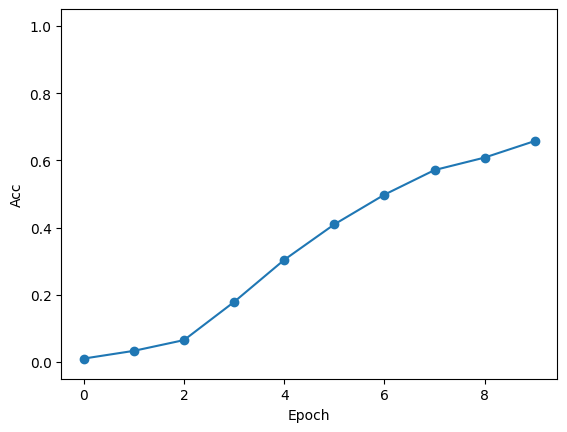

In [31]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
# from attention_seq2seq import AttentionSeq2seq

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=False)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.ylim(-0.05, 1.05)
plt.show()


# Attention Visualization

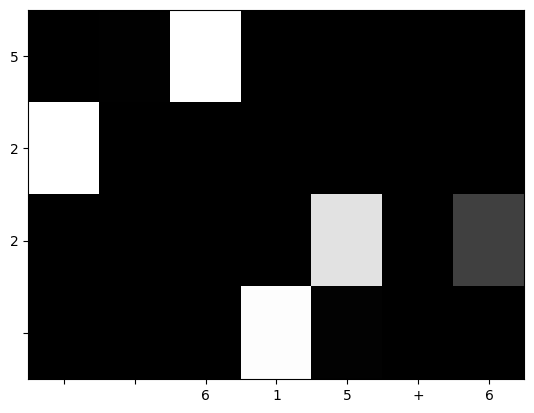

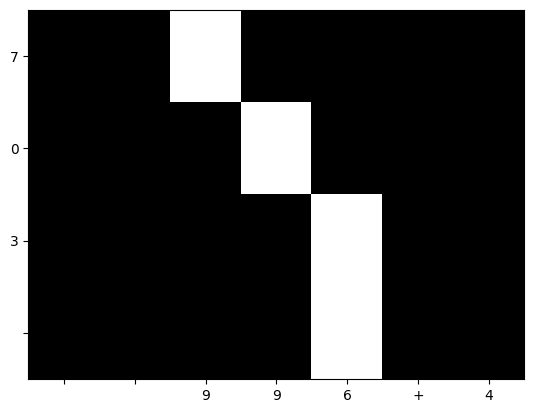

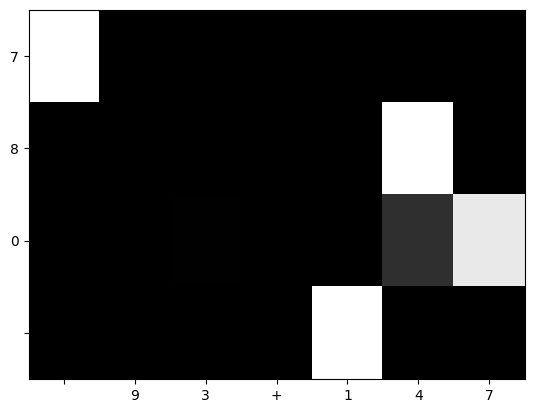

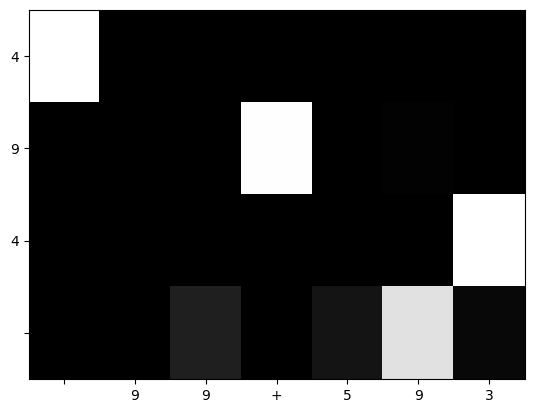

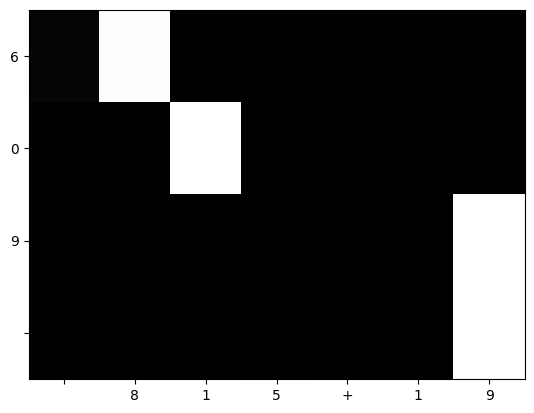

In [32]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights # 마지막에 저장된 attention
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    # 색이 밝을 수록 Attention Score가 높음
    visualize(attention_map, row_labels, column_labels)
